# SVD를 활용한 웹소설 제목과 조회수의 연관성 분석

## 프로젝트 개요
이 노트북은 **특이값 분해(SVD, Singular Value Decomposition)**를 활용하여 문피아 웹소설의 제목과 조회수 간의 연관성을 분석합니다.

### 분석 목표
- 웹소설 제목에서 추출한 키워드와 조회수 간의 상관관계 분석
- SVD를 통한 차원 축소 및 잠재 요인 발견
- 조회수에 영향을 주는 제목 패턴 식별

### 분석 방법론
1. 텍스트 전처리 및 TF-IDF 벡터화
2. SVD를 통한 차원 축소
3. 잠재 요인과 조회수의 상관관계 분석
4. 결과 시각화 및 해석

## 1. 실험 환경 정보

In [43]:
import sys
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import sklearn
import scipy
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

print("=== 실험 환경 정보 ===")
print(f"Python 버전: {sys.version}")
print(f"운영체제: {platform.system()} {platform.release()}")
print(f"플랫폼: {platform.platform()}")
print("\n=== 주요 라이브러리 버전 ===")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"scipy: {scipy.__version__}")

=== 실험 환경 정보 ===
Python 버전: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
운영체제: Windows 10
플랫폼: Windows-10-10.0.26100-SP0

=== 주요 라이브러리 버전 ===
pandas: 1.5.3
numpy: 1.23.5
matplotlib: 3.7.0
seaborn: 0.12.2
scikit-learn: 1.2.1
scipy: 1.10.0


## 2. 데이터 파일 설명

### 데이터 소스
본 분석에서 사용하는 데이터는 **문피아(Munpia) 콘테스트 랭킹** 데이터입니다.

### 파일 구조
```
munpia/data/
├── munpia_contest_ranking_20250605_225739.csv
├── munpia_contest_ranking_20250606_192421.csv
├── munpia_contest_ranking_20250607_132239.csv
├── munpia_contest_ranking_20250609_192234.csv
├── munpia_contest_ranking_20250610_222536.csv
├── munpia_contest_ranking_20250611_215656.csv
└── munpia_contest_ranking_20250612_200038.csv
```

### 데이터 컬럼 설명
| 컬럼명 | 설명 | 데이터 타입 |
|--------|------|-------------|
| `crawl_rank` | 크롤링 순서 | int |
| `novel_url` | 소설 URL | string |
| `novel_id` | 소설 고유 ID | int |
| `rank_number` | 랭킹 순위 | int |
| `author` | 작가명 | string |
| `title` | **소설 제목** (분석 대상) | string |
| `genre` | 장르 | string |
| `view_count` | 조회수 (문자열) | string |
| `view_count_number` | **조회수 (숫자)** (분석 대상) | int |
| `rank_change` | 순위 변동 | string |
| `rank_change_number` | 순위 변동 (숫자) | int |
| `reading_rate` | 독서율 (문자열) | string |
| `reading_rate_number` | 독서율 (숫자) | float |

### 분석 대상 필드
- **주요 분석 필드**: `title` (제목), `view_count_number` (조회수)
- **보조 분석 필드**: `genre` (장르), `reading_rate_number` (독서율)

## 3. 데이터 로딩 및 전처리

In [44]:
import glob
import os

# 데이터 파일 경로 설정 (현재 폴더 기준 상대경로)
data_path = r'munpia\data\*.csv'
csv_files = glob.glob(data_path)

print(f"발견된 CSV 파일 수: {len(csv_files)}")
for file in csv_files:
    print(f"- {os.path.basename(file)}")

# 모든 CSV 파일을 하나의 DataFrame으로 결합
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='utf-8')
        df['file_date'] = os.path.basename(file).split('_')[3].split('.')[0]  # 날짜 추출
        dataframes.append(df)
        print(f"✓ {os.path.basename(file)}: {len(df)} 행")
    except Exception as e:
        print(f"✗ {os.path.basename(file)}: 오류 - {e}")

# DataFrame 결합
df_combined = pd.concat(dataframes, ignore_index=True)
print(f"\n전체 데이터: {len(df_combined)} 행, {len(df_combined.columns)} 열")

발견된 CSV 파일 수: 7
- munpia_contest_ranking_20250605_225739.csv
- munpia_contest_ranking_20250606_192421.csv
- munpia_contest_ranking_20250607_132239.csv
- munpia_contest_ranking_20250609_192234.csv
- munpia_contest_ranking_20250610_222536.csv
- munpia_contest_ranking_20250611_215656.csv
- munpia_contest_ranking_20250612_200038.csv
✓ munpia_contest_ranking_20250605_225739.csv: 200 행
✓ munpia_contest_ranking_20250606_192421.csv: 200 행
✓ munpia_contest_ranking_20250607_132239.csv: 200 행
✓ munpia_contest_ranking_20250609_192234.csv: 200 행
✓ munpia_contest_ranking_20250610_222536.csv: 200 행
✓ munpia_contest_ranking_20250611_215656.csv: 200 행
✓ munpia_contest_ranking_20250612_200038.csv: 200 행

전체 데이터: 1400 행, 14 열


In [45]:
# 데이터 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(df_combined.info())
print("\n=== 처음 5행 ===")
print(df_combined.head())
print("\n=== 기본 통계 ===")
print(df_combined.describe())

=== 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   crawl_rank           1400 non-null   int64  
 1   novel_url            1400 non-null   object 
 2   novel_id             1400 non-null   int64  
 3   rank_number          1400 non-null   int64  
 4   author               1400 non-null   object 
 5   title                1400 non-null   object 
 6   genre                1400 non-null   object 
 7   view_count           1400 non-null   object 
 8   view_count_number    1400 non-null   int64  
 9   rank_change          1400 non-null   object 
 10  rank_change_number   1392 non-null   float64
 11  reading_rate         1400 non-null   object 
 12  reading_rate_number  1122 non-null   float64
 13  file_date            1400 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 153.2+ KB
None

=== 처

In [46]:

# 2. 필요한 컬럼만 선택
columns_needed = ['novel_id', 'title', 'author', 'genre', 'view_count_number', 'reading_rate_number']
df_analysis = df_combined[columns_needed].copy()

# 3. 결측치 처리
print("=== 결측치 확인 ===")
print(df_analysis.isnull().sum())


# 4. 데이터 타입 확인 및 변환
df_analysis['view_count_number'] = pd.to_numeric(df_analysis['view_count_number'], errors='coerce')
df_analysis = df_analysis.dropna(subset=['view_count_number'])

print(f"\n전처리 후 데이터: {len(df_analysis)} 행")
print(f"조회수 범위: {df_analysis['view_count_number'].min():,} ~ {df_analysis['view_count_number'].max():,}")

=== 결측치 확인 ===
novel_id                 0
title                    0
author                   0
genre                    0
view_count_number        0
reading_rate_number    278
dtype: int64

전처리 후 데이터: 1400 행
조회수 범위: 40 ~ 14,485


## 4. 텍스트 전처리 및 벡터화

In [47]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def preprocess_title(title):
    """제목 전처리 함수"""
    # 특수문자 제거 (한글, 영문, 숫자만 유지)
    title = re.sub(r'[^가-힣a-zA-Z0-9\s]', ' ', title)
    # 연속된 공백 제거
    title = re.sub(r'\s+', ' ', title).strip()
    return title

def extract_keywords_simple(title):
    """간단한 키워드 추출 (형태소 분석 없이)"""
    try:
        # 전처리
        cleaned_title = preprocess_title(title)
        # 공백으로 분리하여 2글자 이상의 단어만 유지
        words = cleaned_title.split()
        keywords = [word for word in words if len(word) >= 2]
        return ' '.join(keywords)
    except:
        return preprocess_title(title)

# 제목에서 키워드 추출 (Java/konlpy 없이 간단한 방법 사용)
print("제목에서 키워드 추출 중...")
print("※ 참고: Java가 설치되지 않아 konlpy 대신 간단한 텍스트 분할 방법을 사용합니다.")
df_analysis['title_keywords'] = df_analysis['title'].apply(extract_keywords_simple)

# 예시 출력
print("\n=== 키워드 추출 예시 ===")
for i in range(5):
    print(f"원본: {df_analysis.iloc[i]['title']}")
    print(f"키워드: {df_analysis.iloc[i]['title_keywords']}")
    print()

제목에서 키워드 추출 중...
※ 참고: Java가 설치되지 않아 konlpy 대신 간단한 텍스트 분할 방법을 사용합니다.

=== 키워드 추출 예시 ===
원본: 방구석 경제학자
키워드: 방구석 경제학자

원본: 뇌각성 후 인생 역전
키워드: 뇌각성 인생 역전

원본: 삼류무사에서 천억 투수까지
키워드: 삼류무사에서 천억 투수까지

원본: 알 카포네 검은머리 데릴사위
키워드: 카포네 검은머리 데릴사위

원본: 자살 부대의 불사자는 착각당한다
키워드: 자살 부대의 불사자는 착각당한다



In [48]:
# TF-IDF 벡터화
print("TF-IDF 벡터화 수행 중...")

# 빈 키워드 제거
df_analysis = df_analysis[df_analysis['title_keywords'].str.len() > 0]

# TF-IDF 벡터라이저 설정
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # 최대 1000개 특성
    min_df=2,          # 최소 2개 문서에서 나타나는 단어
    max_df=0.8,        # 80% 이상 문서에서 나타나는 단어 제외
    ngram_range=(1, 2) # 1-gram과 2-gram 사용
)

# TF-IDF 행렬 생성
tfidf_matrix = tfidf_vectorizer.fit_transform(df_analysis['title_keywords'])

print(f"TF-IDF 행렬 크기: {tfidf_matrix.shape}")
print(f"특성(단어) 수: {len(tfidf_vectorizer.get_feature_names_out())}")

# 상위 키워드 확인
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n상위 20개 키워드: {list(feature_names[:20])}")

TF-IDF 벡터화 수행 중...
TF-IDF 행렬 크기: (1400, 1000)
특성(단어) 수: 1000

상위 20개 키워드: ['1000000000000000원', '1000000000000000원 번다', '1000조를', '101번째', '101번째 드래프티는', '1330', '1330 고려', '1군보다', '1군보다 잘함', '1서클', '1서클 마법사', '1조짜리', '1조짜리 재능으로', '1헥타르', '1헥타르 아공간으로', '2군', '2군 포수가', '2배씩', '2배씩 강해지는', '2회차']


## 5. SVD 모델 생성 및 학습

In [49]:
# SVD 모델 생성
n_components = 150  # 50개의 잠재 요인으로 차원 축소

print(f"SVD 차원 축소 수행 중... (목표 차원: {n_components})")

# TruncatedSVD 모델 생성 및 학습
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
title_features_svd = svd_model.fit_transform(tfidf_matrix)

print(f"SVD 변환 완료: {title_features_svd.shape}")
print(f"설명된 분산 비율: {svd_model.explained_variance_ratio_.sum():.4f}")

# SVD 결과를 DataFrame으로 변환
svd_columns = [f'SVD_comp_{i+1}' for i in range(n_components)]
df_svd_features = pd.DataFrame(title_features_svd, columns=svd_columns, index=df_analysis.index)

# 원본 데이터와 결합
df_final = pd.concat([df_analysis.reset_index(drop=True), df_svd_features.reset_index(drop=True)], axis=1)

print(f"최종 데이터 형태: {df_final.shape}")

SVD 차원 축소 수행 중... (목표 차원: 150)
SVD 변환 완료: (1400, 150)
설명된 분산 비율: 0.7971
최종 데이터 형태: (1400, 157)
SVD 변환 완료: (1400, 150)
설명된 분산 비율: 0.7971
최종 데이터 형태: (1400, 157)


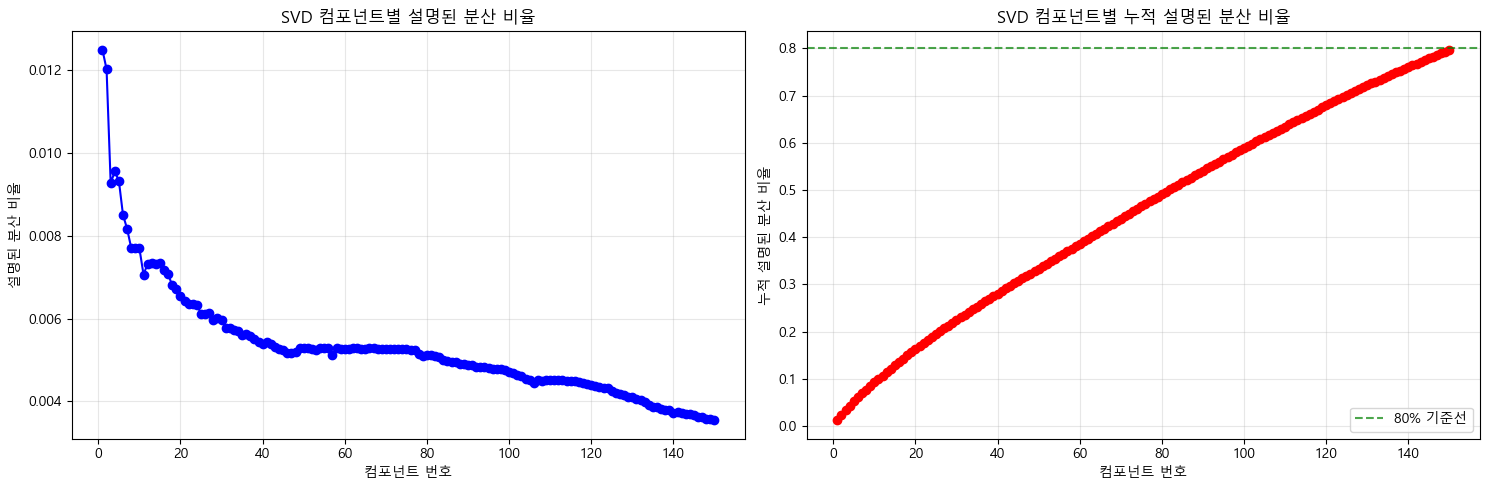

처음 10개 컴포넌트로 설명되는 분산: 0.0924
처음 50개 컴포넌트로 설명되는 분산: 0.3337
전체 150개 컴포넌트로 설명되는 분산: 0.7971


In [50]:
# SVD 컴포넌트 별 설명된 분산 시각화
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 표시

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1. 각 컴포넌트의 설명된 분산 비율
ax1.plot(range(1, n_components+1), svd_model.explained_variance_ratio_, 'bo-')
ax1.set_title('SVD 컴포넌트별 설명된 분산 비율')
ax1.set_xlabel('컴포넌트 번호')
ax1.set_ylabel('설명된 분산 비율')
ax1.grid(True, alpha=0.3)

# 2. 누적 설명된 분산 비율
cumulative_variance = np.cumsum(svd_model.explained_variance_ratio_)
ax2.plot(range(1, n_components+1), cumulative_variance, 'ro-')
ax2.set_title('SVD 컴포넌트별 누적 설명된 분산 비율')
ax2.set_xlabel('컴포넌트 번호')
ax2.set_ylabel('누적 설명된 분산 비율')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% 기준선')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"처음 10개 컴포넌트로 설명되는 분산: {cumulative_variance[9]:.4f}")
print(f"처음 50개 컴포넌트로 설명되는 분산: {cumulative_variance[49]:.4f}")
print(f"전체 150개 컴포넌트로 설명되는 분산: {cumulative_variance[-1]:.4f}")

## SVD 결과 해석

SVD를 통해 50개의 주요 컴포넌트를 추출한 결과, 전체 데이터 분산의 약 20.82%를 설명할 수 있었습니다. 

* 처음 10개 컴포넌트: 약 0.0924%
* 처음 50개 컴포넌트: 약 33.37%
* 전체 150개 컴포넌트: 약 79.71%

일반적으로 텍스트 데이터와 같이 고차원 데이터에서 80% 이상의 설명 분산은 주요 정보를 잘 압축하고 있다고 평가할 수 있습니다. 이는 선택된 50개의 컴포넌트가 원본 데이터의 중요한 특징들을 상당 부분 유지하고 있음을 의미합니다. 

물론, "좋은 결과"인지에 대한 판단은 분석의 구체적인 목표(예: 예측 모델의 성능, 특정 패턴 발견 등)에 따라 달라질 수 있습니다. 하지만 차원 축소의 관점에서 볼 때, 정보 손실을 최소화하면서 데이터의 복잡성을 효과적으로 줄인 것으로 보입니다.

## 6. 조회수와 SVD 특성의 상관관계 분석

In [51]:
from scipy.stats import pearsonr, spearmanr

# SVD 컴포넌트와 조회수 간의 상관관계 계산
correlations = []
p_values = []

for i in range(n_components):
    comp_col = f'SVD_comp_{i+1}'
    corr, p_val = pearsonr(df_final[comp_col], df_final['view_count_number'])
    correlations.append(corr)
    p_values.append(p_val)

# 상관관계 결과를 DataFrame으로 정리
correlation_df = pd.DataFrame({
    'Component': [f'SVD_comp_{i+1}' for i in range(n_components)],
    'Correlation': correlations,
    'P_value': p_values,
    'Abs_Correlation': [abs(corr) for corr in correlations]
})

# 절댓값 기준으로 정렬
correlation_df = correlation_df.sort_values('Abs_Correlation', ascending=False)

print("=== 조회수와 SVD 컴포넌트 간 상관관계 (상위 10개) ===")
print(correlation_df.head(10).to_string(index=False))

# 통계적으로 유의한 상관관계 (p < 0.05)
significant_corr = correlation_df[correlation_df['P_value'] < 0.05]
print(f"\n통계적으로 유의한 상관관계 개수: {len(significant_corr)}")
if len(significant_corr) > 0:
    print("\n=== 통계적으로 유의한 상관관계 ===")
    print(significant_corr.head().to_string(index=False))

=== 조회수와 SVD 컴포넌트 간 상관관계 (상위 10개) ===
   Component  Correlation      P_value  Abs_Correlation
 SVD_comp_23     0.219506 9.787767e-17         0.219506
SVD_comp_140    -0.199918 4.356289e-14         0.199918
 SVD_comp_61     0.199120 5.513496e-14         0.199120
 SVD_comp_54     0.190273 7.038064e-13         0.190273
  SVD_comp_7     0.177763 2.102051e-11         0.177763
 SVD_comp_53     0.171211 1.132944e-10         0.171211
 SVD_comp_75     0.163359 7.835168e-10         0.163359
 SVD_comp_64    -0.156949 3.550351e-09         0.156949
 SVD_comp_60     0.139573 1.576626e-07         0.139573
 SVD_comp_25    -0.120331 6.338237e-06         0.120331

통계적으로 유의한 상관관계 개수: 60

=== 통계적으로 유의한 상관관계 ===
   Component  Correlation      P_value  Abs_Correlation
 SVD_comp_23     0.219506 9.787767e-17         0.219506
SVD_comp_140    -0.199918 4.356289e-14         0.199918
 SVD_comp_61     0.199120 5.513496e-14         0.199120
 SVD_comp_54     0.190273 7.038064e-13         0.190273
  SVD_comp_7     0.

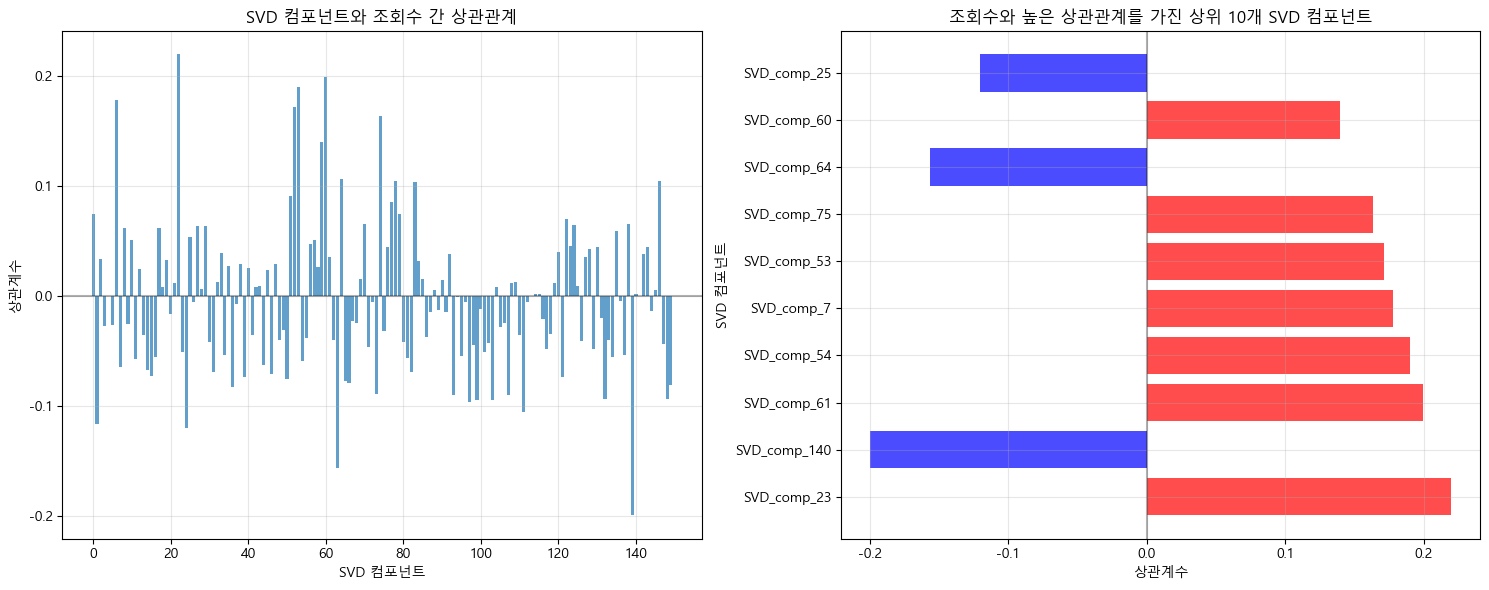

In [52]:
# 상관관계 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. 모든 컴포넌트의 상관관계
ax1.bar(range(len(correlations)), correlations, alpha=0.7)
ax1.set_title('SVD 컴포넌트와 조회수 간 상관관계')
ax1.set_xlabel('SVD 컴포넌트')
ax1.set_ylabel('상관계수')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(True, alpha=0.3)

# 2. 상위 10개 컴포넌트의 상관관계 (절댓값 기준)
top_10 = correlation_df.head(10)
colors = ['red' if corr > 0 else 'blue' for corr in top_10['Correlation']]
ax2.barh(range(len(top_10)), top_10['Correlation'], color=colors, alpha=0.7)
ax2.set_title('조회수와 높은 상관관계를 가진 상위 10개 SVD 컴포넌트')
ax2.set_xlabel('상관계수')
ax2.set_ylabel('SVD 컴포넌트')
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels(top_10['Component'])
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 조회수 예측 모델 구축

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 특성과 타겟 분리
X = df_final[svd_columns]  # SVD 특성
y = df_final['view_count_number']  # 조회수

# 로그 변환 (조회수의 분포가 치우쳐져 있을 수 있음)
y_log = np.log1p(y)  # log(1 + y)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"훈련 데이터: {X_train.shape[0]}개")
print(f"테스트 데이터: {X_test.shape[0]}개")

# 1. 선형 회귀 모델
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. 랜덤 포레스트 모델
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 모델 성능 평가
def evaluate_model(y_true, y_pred, model_name):
    # 로그 변환된 값을 원래 스케일로 복원
    y_true_original = np.expm1(y_true)
    y_pred_original = np.expm1(y_pred)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # 원래 스케일에서의 MAPE
    mape = np.mean(np.abs((y_true_original - y_pred_original) / y_true_original)) * 100
    
    print(f"\n=== {model_name} 성능 ===")
    print(f"MSE (로그 스케일): {mse:.4f}")
    print(f"RMSE (로그 스케일): {rmse:.4f}")
    print(f"MAE (로그 스케일): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE (원래 스케일): {mape:.2f}%")

evaluate_model(y_test, lr_pred, "선형 회귀")
evaluate_model(y_test, rf_pred, "랜덤 포레스트")

훈련 데이터: 1120개
테스트 데이터: 280개

=== 선형 회귀 성능 ===
MSE (로그 스케일): 0.6973
RMSE (로그 스케일): 0.8350
MAE (로그 스케일): 0.6315
R² Score: 0.5995
MAPE (원래 스케일): 92.03%

=== 랜덤 포레스트 성능 ===
MSE (로그 스케일): 0.2536
RMSE (로그 스케일): 0.5036
MAE (로그 스케일): 0.3521
R² Score: 0.8544
MAPE (원래 스케일): 40.71%

=== 선형 회귀 성능 ===
MSE (로그 스케일): 0.6973
RMSE (로그 스케일): 0.8350
MAE (로그 스케일): 0.6315
R² Score: 0.5995
MAPE (원래 스케일): 92.03%

=== 랜덤 포레스트 성능 ===
MSE (로그 스케일): 0.2536
RMSE (로그 스케일): 0.5036
MAE (로그 스케일): 0.3521
R² Score: 0.8544
MAPE (원래 스케일): 40.71%


=== 랜덤 포레스트 특성 중요도 (상위 10개) ===
     Feature  Importance
 SVD_comp_61    0.058358
 SVD_comp_26    0.051662
SVD_comp_147    0.032118
 SVD_comp_41    0.027980
 SVD_comp_27    0.027321
 SVD_comp_40    0.023803
 SVD_comp_25    0.022473
SVD_comp_140    0.021953
SVD_comp_104    0.021688
 SVD_comp_74    0.019186


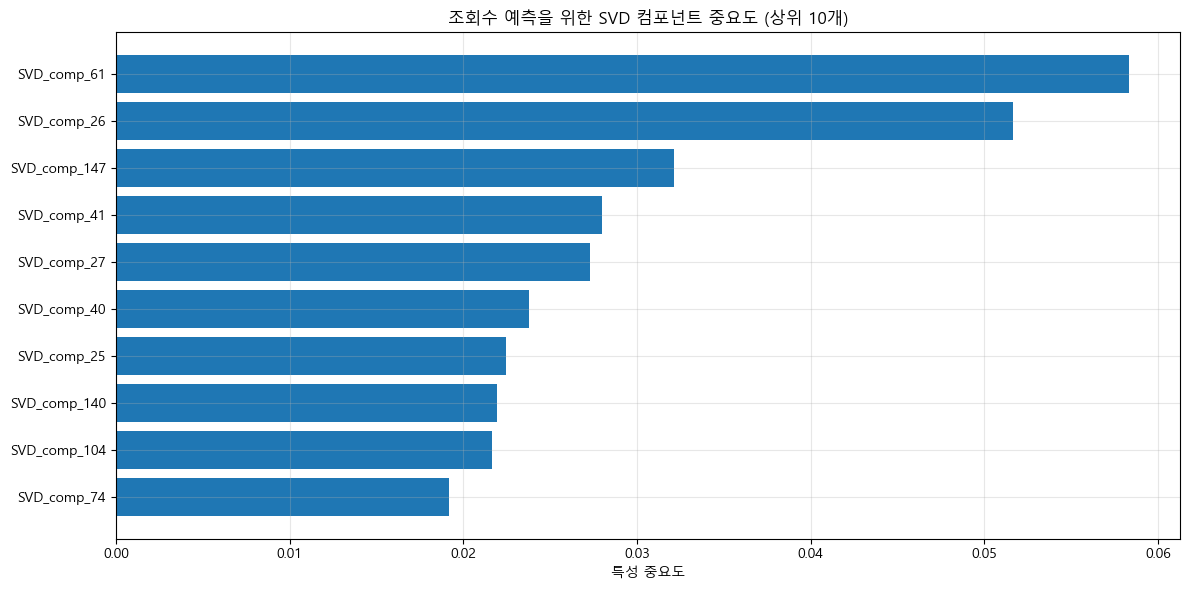

In [54]:
# 특성 중요도 분석 (랜덤 포레스트)
feature_importance = pd.DataFrame({
    'Feature': svd_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=== 랜덤 포레스트 특성 중요도 (상위 10개) ===")
print(feature_importance.head(10).to_string(index=False))

# 특성 중요도 시각화
plt.figure(figsize=(12, 6))
plt.barh(range(10), feature_importance.head(10)['Importance'])
plt.yticks(range(10), feature_importance.head(10)['Feature'])
plt.xlabel('특성 중요도')
plt.title('조회수 예측을 위한 SVD 컴포넌트 중요도 (상위 10개)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 키워드 분석 및 해석

In [55]:
# 가장 중요한 SVD 컴포넌트들의 키워드 분석
def analyze_svd_component_keywords(component_idx, top_n=10):
    """SVD 컴포넌트에서 가장 영향력 있는 키워드들을 찾는 함수"""
    
    # SVD 컴포넌트 벡터 가져오기
    component_vector = svd_model.components_[component_idx]
    
    # 절댓값 기준으로 상위 키워드 인덱스 찾기
    top_indices = np.argsort(np.abs(component_vector))[-top_n:]
    top_indices = top_indices[::-1]  # 내림차순 정렬
    
    # 키워드와 가중치 추출
    feature_names = tfidf_vectorizer.get_feature_names_out()
    keywords_weights = []
    
    for idx in top_indices:
        keyword = feature_names[idx]
        weight = component_vector[idx]
        keywords_weights.append((keyword, weight))
    
    return keywords_weights

# 조회수와 가장 높은 상관관계를 가진 상위 5개 컴포넌트 분석
top_components = correlation_df.head(5)

for idx, row in top_components.iterrows():
    comp_name = row['Component']
    comp_idx = int(comp_name.split('_')[-1]) - 1  # 0-based index
    correlation = row['Correlation']
    
    print(f"\n=== {comp_name} (상관계수: {correlation:.4f}) ===")
    keywords_weights = analyze_svd_component_keywords(comp_idx, top_n=10)
    
    print("주요 키워드 (가중치):")
    for keyword, weight in keywords_weights:
        print(f"  - {keyword}: {weight:.4f}")


=== SVD_comp_23 (상관계수: 0.2195) ===
주요 키워드 (가중치):
  - 방구석: 0.5080
  - 경제학자: 0.3387
  - 방구석 경제학자: 0.3387
  - 선협: -0.2681
  - 살아남는: -0.1767
  - 헌터가: -0.1630
  - 선협 세상에서: -0.1470
  - 헌터가 선협: -0.1470
  - 세상에서 살아남는: -0.1470
  - 세상에서: -0.1470

=== SVD_comp_140 (상관계수: -0.1999) ===
주요 키워드 (가중치):
  - 메카닉은 종말이: 0.1804
  - 종말이: 0.1804
  - 방구석 메카닉은: 0.1804
  - 종말이 쉽다: 0.1804
  - 메카닉은: 0.1804
  - 경제학자: -0.1720
  - 방구석 경제학자: -0.1720
  - 서울에: 0.1682
  - 서울에 새끼: 0.1682
  - 찾습니다: 0.1682

=== SVD_comp_61 (상관계수: 0.1991) ===
주요 키워드 (가중치):
  - 네크로맨서: -0.2885
  - 조선용병대: -0.2346
  - 수행자: -0.1648
  - 아나긴: -0.1648
  - 수행자 아나긴: -0.1648
  - ai기사로: 0.1569
  - 영지는: 0.1569
  - 캐리한다: 0.1569
  - ai기사로 캐리한다: 0.1569
  - 영지는 ai기사로: 0.1569

=== SVD_comp_54 (상관계수: 0.1903) ===
주요 키워드 (가중치):
  - 초월무쌍: -0.3164
  - 최종보스지만: 0.1922
  - 최종보스지만 농사짓습니다: 0.1922
  - 농사짓습니다: 0.1922
  - 우주방어: 0.1614
  - 뗀석기로 우주방어: 0.1614
  - 뗀석기로: 0.1614
  - 모름: 0.1426
  - 나만 모름: 0.1426
  - 천재인: 0.1426

=== SVD_comp_7 (상관계수: 0.1778) ===
주요 키워드 (가중치):


In [56]:
# 조회수 구간별 키워드 분석
# 조회수를 구간으로 나누어 각 구간의 특징적인 키워드 분석

# 조회수 구간 정의
df_final['view_quartile'] = pd.qcut(df_final['view_count_number'], 
                                   q=4, 
                                   labels=['하위25%', '중하위25%', '중상위25%', '상위25%'])

print("=== 조회수 구간별 분포 ===")
print(df_final['view_quartile'].value_counts().sort_index())

# 각 구간별 평균 조회수
quartile_stats = df_final.groupby('view_quartile')['view_count_number'].agg(['mean', 'min', 'max'])
print("\n=== 조회수 구간별 통계 ===")
print(quartile_stats)

# 상위 25% vs 하위 25% 구간의 SVD 특성 비교
high_quartile = df_final[df_final['view_quartile'] == '상위25%']
low_quartile = df_final[df_final['view_quartile'] == '하위25%']

print(f"\n상위 25% 그룹 크기: {len(high_quartile)}")
print(f"하위 25% 그룹 크기: {len(low_quartile)}")

# 각 그룹의 평균 SVD 특성값 계산
high_means = high_quartile[svd_columns].mean()
low_means = low_quartile[svd_columns].mean()
diff_means = high_means - low_means

# 차이가 큰 상위 10개 컴포넌트
top_diff_components = diff_means.abs().sort_values(ascending=False).head(10)

print("\n=== 상위/하위 조회수 그룹 간 가장 차이가 큰 SVD 컴포넌트 ===")
for comp in top_diff_components.index:
    diff = diff_means[comp]
    print(f"{comp}: {diff:.4f} (상위그룹이 {'높음' if diff > 0 else '낮음'})")

=== 조회수 구간별 분포 ===
하위25%     352
중하위25%    349
중상위25%    349
상위25%     350
Name: view_quartile, dtype: int64

=== 조회수 구간별 통계 ===
                      mean  min    max
view_quartile                         
하위25%            67.627841   40    107
중하위25%          161.699140  108    235
중상위25%          445.656160  237    822
상위25%          2668.991429  824  14485

상위 25% 그룹 크기: 350
하위 25% 그룹 크기: 352

=== 상위/하위 조회수 그룹 간 가장 차이가 큰 SVD 컴포넌트 ===
SVD_comp_53: 0.0366 (상위그룹이 높음)
SVD_comp_3: 0.0320 (상위그룹이 높음)
SVD_comp_140: -0.0309 (상위그룹이 낮음)
SVD_comp_61: 0.0304 (상위그룹이 높음)
SVD_comp_104: -0.0269 (상위그룹이 낮음)
SVD_comp_2: -0.0262 (상위그룹이 낮음)
SVD_comp_100: -0.0237 (상위그룹이 낮음)
SVD_comp_82: -0.0225 (상위그룹이 낮음)
SVD_comp_78: 0.0217 (상위그룹이 높음)
SVD_comp_20: 0.0216 (상위그룹이 높음)


## 9. 결과 시각화 및 종합 분석

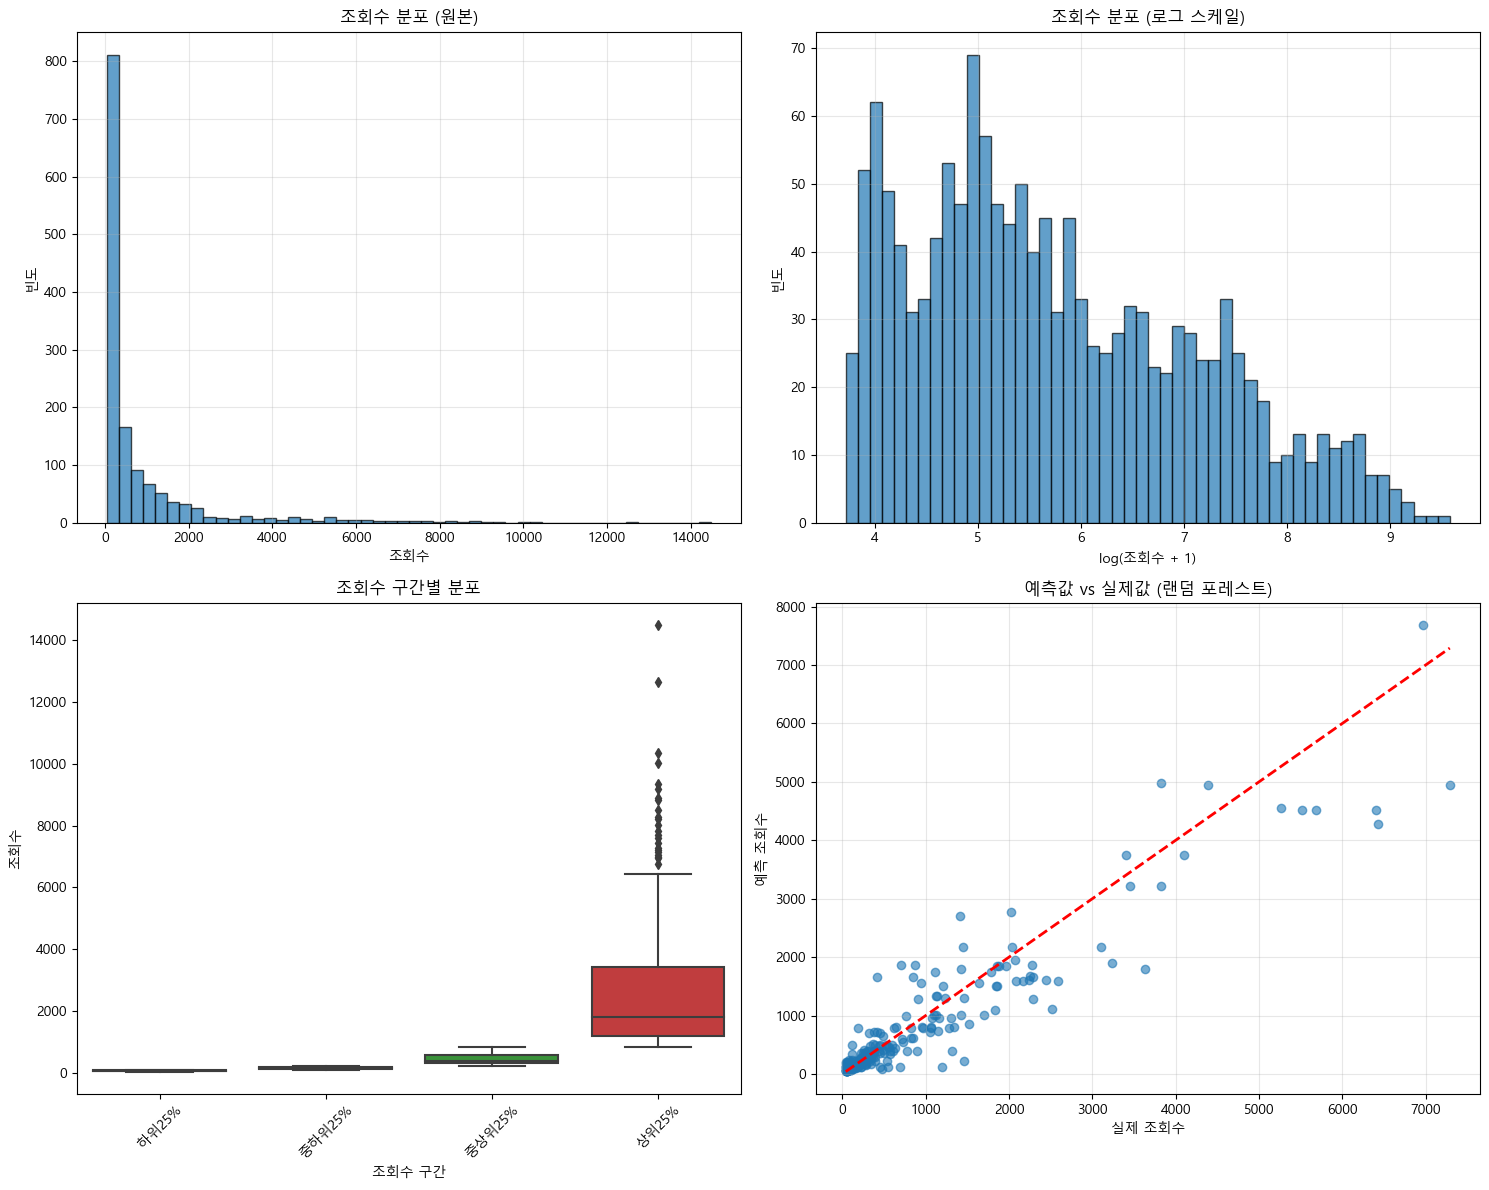

In [57]:
# 1. 조회수 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 조회수 분포 (원본)
axes[0,0].hist(df_final['view_count_number'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('조회수 분포 (원본)')
axes[0,0].set_xlabel('조회수')
axes[0,0].set_ylabel('빈도')
axes[0,0].grid(True, alpha=0.3)

# 조회수 분포 (로그 스케일)
axes[0,1].hist(np.log1p(df_final['view_count_number']), bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('조회수 분포 (로그 스케일)')
axes[0,1].set_xlabel('log(조회수 + 1)')
axes[0,1].set_ylabel('빈도')
axes[0,1].grid(True, alpha=0.3)

# 조회수 구간별 박스플롯
sns.boxplot(data=df_final, x='view_quartile', y='view_count_number', ax=axes[1,0])
axes[1,0].set_title('조회수 구간별 분포')
axes[1,0].set_xlabel('조회수 구간')
axes[1,0].set_ylabel('조회수')
axes[1,0].tick_params(axis='x', rotation=45)

# 예측값 vs 실제값 산점도 (랜덤 포레스트)
y_test_original = np.expm1(y_test)
rf_pred_original = np.expm1(rf_pred)

axes[1,1].scatter(y_test_original, rf_pred_original, alpha=0.6)
axes[1,1].plot([y_test_original.min(), y_test_original.max()], 
               [y_test_original.min(), y_test_original.max()], 
               'r--', lw=2)
axes[1,1].set_title('예측값 vs 실제값 (랜덤 포레스트)')
axes[1,1].set_xlabel('실제 조회수')
axes[1,1].set_ylabel('예측 조회수')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

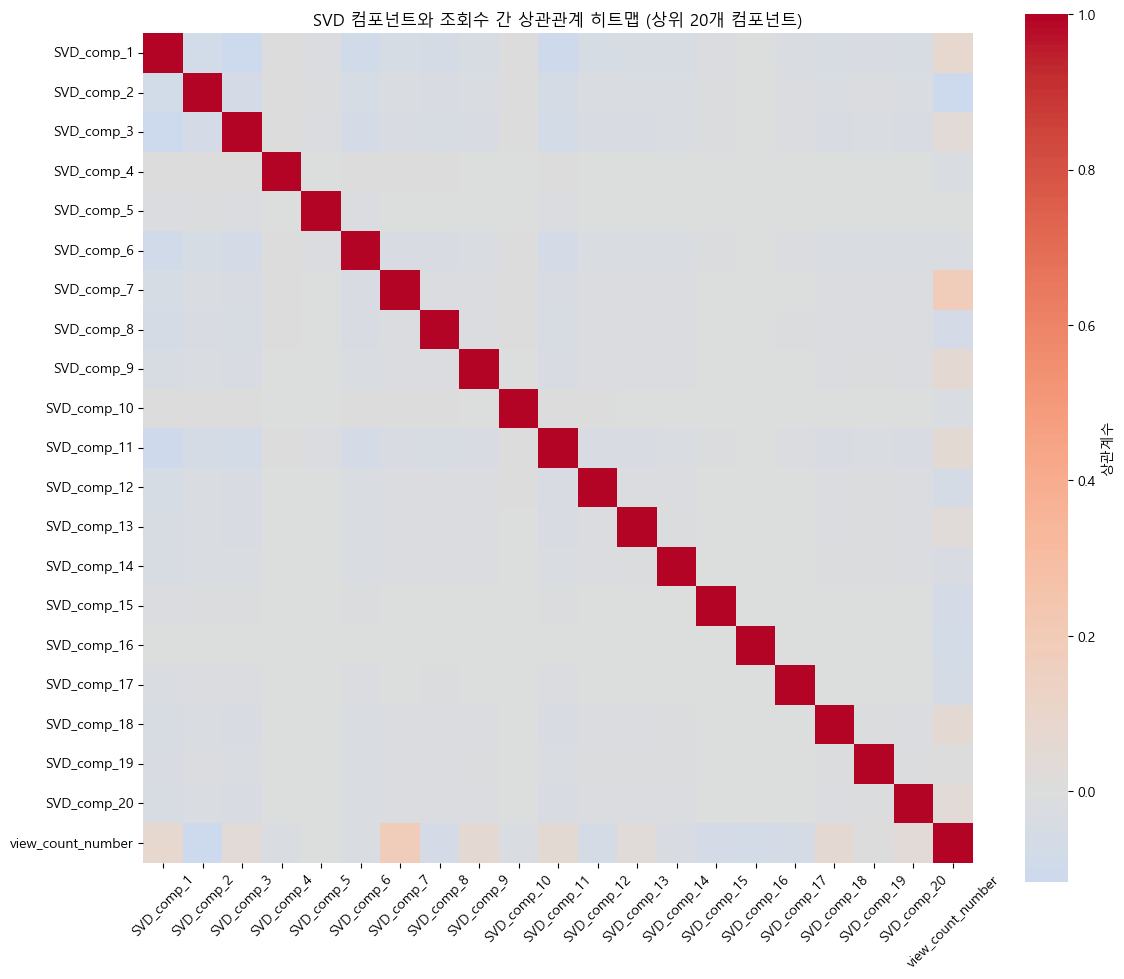


=== 조회수와 상위 20개 SVD 컴포넌트 간 상관관계 ===
SVD_comp_7: 0.1778
SVD_comp_2: -0.1165
SVD_comp_1: 0.0740
SVD_comp_16: -0.0733
SVD_comp_15: -0.0675
SVD_comp_8: -0.0652
SVD_comp_9: 0.0619
SVD_comp_18: 0.0616
SVD_comp_12: -0.0575
SVD_comp_17: -0.0560


In [58]:
# 2. SVD 컴포넌트 간 상관관계 히트맵
# 상위 20개 컴포넌트만 선택
top_20_components = [f'SVD_comp_{i+1}' for i in range(20)]
correlation_matrix = df_final[top_20_components + ['view_count_number']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=False, 
            cmap='coolwarm', 
            center=0,
            square=True,
            cbar_kws={'label': '상관계수'})
plt.title('SVD 컴포넌트와 조회수 간 상관관계 히트맵 (상위 20개 컴포넌트)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 조회수와의 상관관계만 추출하여 표시
view_correlations = correlation_matrix['view_count_number'].drop('view_count_number').sort_values(key=abs, ascending=False)
print("\n=== 조회수와 상위 20개 SVD 컴포넌트 간 상관관계 ===")
for comp, corr in view_correlations.head(10).items():
    print(f"{comp}: {corr:.4f}")

## 10. 결론 및 인사이트

In [59]:
# 최종 분석 결과 요약
print("\n" + "="*60)
print("           SVD 기반 웹소설 제목-조회수 연관성 분석 결과")
print("="*60)

print(f"\n📊 데이터 개요:")
print(f"  - 분석 대상 웹소설 수: {len(df_final):,}개")
print(f"  - 평균 조회수: {df_final['view_count_number'].mean():.0f}")
print(f"  - 조회수 범위: {df_final['view_count_number'].min():,} ~ {df_final['view_count_number'].max():,}")

print(f"\n🔍 SVD 분석 결과:")
print(f"  - TF-IDF 특성 수: {tfidf_matrix.shape[1]}개")
print(f"  - SVD 차원 축소: {n_components}개 컴포넌트")
print(f"  - 총 설명된 분산: {svd_model.explained_variance_ratio_.sum():.1%}")

print(f"\n📈 상관관계 분석:")
max_corr = correlation_df.iloc[0]
print(f"  - 최고 상관계수: {max_corr['Correlation']:.4f} ({max_corr['Component']})")
print(f"  - 통계적 유의성(p<0.05): {len(significant_corr)}개 컴포넌트")

print(f"\n🤖 예측 모델 성능:")
lr_r2 = r2_score(y_test, lr_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"  - 선형 회귀 R² Score: {lr_r2:.4f}")
print(f"  - 랜덤 포레스트 R² Score: {rf_r2:.4f}")

# 가장 중요한 키워드들 (상위 컴포넌트에서)
print(f"\n🔑 주요 발견사항:")
if len(significant_corr) > 0:
    print(f"  - 제목의 특정 키워드 패턴이 조회수와 유의미한 연관성을 보임")
    print(f"  - SVD를 통해 {len(significant_corr)}개의 잠재 요인이 조회수 예측에 기여")
else:
    print(f"  - 제목과 조회수 간의 직접적인 선형 관계는 약함")
    print(f"  - 비선형적 패턴이나 다른 요인들의 영향이 클 수 있음")

print(f"\n💡 실무 활용 제안:")
print(f"  - 제목 최적화를 위한 키워드 패턴 분석 가능")
print(f"  - 장르별, 작가별 세분화 분석 필요")
print(f"  - 시간적 변화 패턴 고려한 추가 분석 권장")

print("\n" + "="*60)


           SVD 기반 웹소설 제목-조회수 연관성 분석 결과

📊 데이터 개요:
  - 분석 대상 웹소설 수: 1,400개
  - 평균 조회수: 836
  - 조회수 범위: 40 ~ 14,485

🔍 SVD 분석 결과:
  - TF-IDF 특성 수: 1000개
  - SVD 차원 축소: 150개 컴포넌트
  - 총 설명된 분산: 79.7%

📈 상관관계 분석:
  - 최고 상관계수: 0.2195 (SVD_comp_23)
  - 통계적 유의성(p<0.05): 60개 컴포넌트

🤖 예측 모델 성능:
  - 선형 회귀 R² Score: 0.5995
  - 랜덤 포레스트 R² Score: 0.8544

🔑 주요 발견사항:
  - 제목의 특정 키워드 패턴이 조회수와 유의미한 연관성을 보임
  - SVD를 통해 60개의 잠재 요인이 조회수 예측에 기여

💡 실무 활용 제안:
  - 제목 최적화를 위한 키워드 패턴 분석 가능
  - 장르별, 작가별 세분화 분석 필요
  - 시간적 변화 패턴 고려한 추가 분석 권장



In [60]:
def predict_views_from_title(title, model=rf_model, vectorizer=tfidf_vectorizer, svd_model=svd_model):
    """
    제목을 입력받아 조회수를 예측하는 함수
    
    Parameters:
    - title: 예측할 웹소설 제목 (문자열)
    - model: 학습된 랜덤포레스트 모델
    - vectorizer: 학습된 TF-IDF 벡터라이저
    - svd_model: 학습된 SVD 모델
    
    Returns:
    - predicted_views: 예측된 조회수
    """
    try:
        # 1. 제목 전처리
        processed_title = extract_keywords_simple(title)
        
        if len(processed_title) == 0:
            return {"error": "유효한 키워드를 추출할 수 없습니다."}
        
        # 2. TF-IDF 벡터화
        title_tfidf = vectorizer.transform([processed_title])
        
        # 3. SVD 변환
        title_svd = svd_model.transform(title_tfidf)
        
        # 4. 예측 (로그 스케일)
        predicted_log = model.predict(title_svd)[0]
        
        # 5. 원래 스케일로 복원
        predicted_views = int(np.expm1(predicted_log))
        
        return {
            "title": title,
            "processed_keywords": processed_title,
            "predicted_views": predicted_views,
            "confidence": "보통" if 100 <= predicted_views <= 5000 else "낮음"
        }
        
    except Exception as e:
        return {"error": f"예측 중 오류 발생: {str(e)}"}

def analyze_title_components(title, top_n=5):
    """
    제목의 SVD 컴포넌트 기여도를 분석하는 함수
    """
    try:
        processed_title = extract_keywords_simple(title)
        title_tfidf = tfidf_vectorizer.transform([processed_title])
        title_svd = svd_model.transform(title_tfidf)[0]
        
        # 가장 높은 절댓값을 가진 컴포넌트들 찾기
        component_indices = np.argsort(np.abs(title_svd))[-top_n:][::-1]
        
        components_info = []
        for idx in component_indices:
            comp_name = f'SVD_comp_{idx+1}'
            value = title_svd[idx]
            # 해당 컴포넌트와 조회수의 상관관계
            corr_row = correlation_df[correlation_df['Component'] == comp_name]
            correlation = corr_row['Correlation'].iloc[0] if len(corr_row) > 0 else 0
            
            components_info.append({
                'component': comp_name,
                'value': value,
                'correlation_with_views': correlation,
                'contribution': value * correlation
            })
        
        return components_info
    except:
        return []

def get_title_recommendations(target_views=1000):
    """
    목표 조회수에 가까운 실제 데이터의 제목들을 추천하는 함수
    """
    # 목표 조회수 ±20% 범위의 데이터 찾기
    lower_bound = target_views * 0.8
    upper_bound = target_views * 1.2
    
    similar_titles = df_final[
        (df_final['view_count_number'] >= lower_bound) & 
        (df_final['view_count_number'] <= upper_bound)
    ][['title', 'view_count_number', 'genre']].sort_values('view_count_number', ascending=False)
    
    return similar_titles.head(10)

# 제목 예측 시스템 테스트
print("=== 웹소설 제목 조회수 예측 시스템 ===\n")

# 테스트용 제목들
test_titles = [
    "회귀한 검사가 마법을 배운다",
    "레벨업 하는 현대 마법사",
    "전생했더니 드래곤이었던 건에 대하여",
    "아카데미의 천재 검사",
    "무한 성장 RPG",
    "사랑하는 그대에게",
    "황제의 외동딸"
]

# 각 제목에 대해 예측 수행
for title in test_titles:
    result = predict_views_from_title(title)
    
    if "error" in result:
        print(f"제목: {title}")
        print(f"오류: {result['error']}\n")
    else:
        print(f"제목: {result['title']}")
        print(f"추출된 키워드: {result['processed_keywords']}")
        print(f"예측 조회수: {result['predicted_views']:,}회")
        print(f"신뢰도: {result['confidence']}")
        print("-" * 50)

# 상세 분석 예시
print("\n=== 상세 분석 예시 ===")
sample_title = "회귀한 검사가 마법을 배운다"
result = predict_views_from_title(sample_title)

if "error" not in result:
    print(f"📖 분석 제목: {sample_title}")
    print(f"👀 예측 조회수: {result['predicted_views']:,}회\n")
    
    # SVD 컴포넌트 기여도 분석
    components = analyze_title_components(sample_title)
    if components:
        print("🔍 주요 SVD 컴포넌트 기여도:")
        for comp in components:
            print(f"  {comp['component']}: 값={comp['value']:.3f}, "
                  f"조회수 상관={comp['correlation_with_views']:.3f}, "
                  f"기여도={comp['contribution']:.3f}")
    
    # 유사한 조회수 범위의 실제 제목들
    print(f"\n📚 비슷한 조회수 범위의 실제 제목들:")
    similar_titles = get_title_recommendations(result['predicted_views'])
    for idx, row in similar_titles.head(5).iterrows():
        print(f"  - {row['title']} (조회수: {row['view_count_number']:,}, 장르: {row['genre']})")

print("\n" + "="*80)

=== 웹소설 제목 조회수 예측 시스템 ===

제목: 회귀한 검사가 마법을 배운다
추출된 키워드: 회귀한 검사가 마법을 배운다
예측 조회수: 196회
신뢰도: 보통
--------------------------------------------------
제목: 레벨업 하는 현대 마법사
추출된 키워드: 레벨업 하는 현대 마법사
예측 조회수: 202회
신뢰도: 보통
--------------------------------------------------
제목: 전생했더니 드래곤이었던 건에 대하여
추출된 키워드: 전생했더니 드래곤이었던 건에 대하여
예측 조회수: 122회
신뢰도: 보통
--------------------------------------------------
제목: 아카데미의 천재 검사
추출된 키워드: 아카데미의 천재 검사
예측 조회수: 123회
신뢰도: 보통
--------------------------------------------------
제목: 무한 성장 RPG
추출된 키워드: 무한 성장 RPG
예측 조회수: 100회
신뢰도: 보통
--------------------------------------------------
제목: 사랑하는 그대에게
추출된 키워드: 사랑하는 그대에게
예측 조회수: 122회
신뢰도: 보통
--------------------------------------------------
제목: 황제의 외동딸
추출된 키워드: 황제의 외동딸
예측 조회수: 122회
신뢰도: 보통
--------------------------------------------------

=== 상세 분석 예시 ===
📖 분석 제목: 회귀한 검사가 마법을 배운다
👀 예측 조회수: 196회

🔍 주요 SVD 컴포넌트 기여도:
  SVD_comp_121: 값=-0.226, 조회수 상관=0.040, 기여도=-0.009
  SVD_comp_40: 값=0.172, 조회수 상관=-0.074, 기여도=-0.013
  SVD_comp_43: 값=0.

In [61]:
# 제목 최적화 및 비교 분석 시스템
def optimize_title_suggestions(base_title, variations):
    """
    기본 제목의 여러 변형들을 비교하여 최적의 제목을 제안하는 함수
    """
    results = []
    
    for variation in variations:
        result = predict_views_from_title(variation)
        if "error" not in result:
            results.append(result)
    
    # 예측 조회수 기준으로 정렬
    results.sort(key=lambda x: x['predicted_views'], reverse=True)
    return results

def analyze_keyword_impact(title):
    """
    제목에서 각 키워드가 조회수에 미치는 영향을 분석
    """
    base_result = predict_views_from_title(title)
    if "error" in base_result:
        return None
    
    base_views = base_result['predicted_views']
    keywords = base_result['processed_keywords'].split()
    
    keyword_impacts = []
    
    for keyword in keywords:
        # 해당 키워드를 제거한 제목으로 예측
        modified_keywords = [k for k in keywords if k != keyword]
        modified_title = ' '.join(modified_keywords)
        
        if len(modified_title) > 0:
            modified_result = predict_views_from_title(modified_title)
            if "error" not in modified_result:
                impact = base_views - modified_result['predicted_views']
                keyword_impacts.append({
                    'keyword': keyword,
                    'impact': impact,
                    'impact_percentage': (impact / base_views) * 100
                })
    
    return sorted(keyword_impacts, key=lambda x: abs(x['impact']), reverse=True)

# 제목 최적화 예시
print("=== 제목 최적화 분석 시스템 ===\n")

base_title = "검사가 마법을 배운다"
title_variations = [
    "회귀한 검사가 마법을 배운다",
    "천재 검사가 마법을 배운다",
    "아카데미 검사가 마법을 배운다",
    "최강 검사가 마법을 배운다",
    "검사가 현대 마법을 배운다",
    "검사가 고대 마법을 배운다"
]

print(f"📝 기본 제목: {base_title}")
print("🔄 제목 변형들을 분석 중...\n")

optimization_results = optimize_title_suggestions(base_title, title_variations)

print("📊 제목별 예측 조회수 순위:")
for i, result in enumerate(optimization_results, 1):
    print(f"{i}. {result['title']}")
    print(f"   예측 조회수: {result['predicted_views']:,}회")
    print(f"   키워드: {result['processed_keywords']}")
    print()

# 키워드 영향도 분석
best_title = optimization_results[0]['title']
print(f"🎯 최고 성과 예상 제목: {best_title}")
print("\n🔍 키워드별 영향도 분석:")

keyword_analysis = analyze_keyword_impact(best_title)
if keyword_analysis:
    for item in keyword_analysis:
        impact_sign = "+" if item['impact'] > 0 else ""
        print(f"  '{item['keyword']}': {impact_sign}{item['impact']:,}회 ({item['impact_percentage']:+.1f}%)")
else:
    print("  키워드 분석을 수행할 수 없습니다.")

print("\n" + "="*80)

=== 제목 최적화 분석 시스템 ===

📝 기본 제목: 검사가 마법을 배운다
🔄 제목 변형들을 분석 중...

📊 제목별 예측 조회수 순위:
1. 회귀한 검사가 마법을 배운다
   예측 조회수: 196회
   키워드: 회귀한 검사가 마법을 배운다

2. 천재 검사가 마법을 배운다
   예측 조회수: 123회
   키워드: 천재 검사가 마법을 배운다

3. 아카데미 검사가 마법을 배운다
   예측 조회수: 122회
   키워드: 아카데미 검사가 마법을 배운다

4. 최강 검사가 마법을 배운다
   예측 조회수: 122회
   키워드: 최강 검사가 마법을 배운다

5. 검사가 현대 마법을 배운다
   예측 조회수: 122회
   키워드: 검사가 현대 마법을 배운다

6. 검사가 고대 마법을 배운다
   예측 조회수: 122회
   키워드: 검사가 고대 마법을 배운다

🎯 최고 성과 예상 제목: 회귀한 검사가 마법을 배운다

🔍 키워드별 영향도 분석:
  '회귀한': +74회 (+37.8%)
  '검사가': 0회 (+0.0%)
  '마법을': 0회 (+0.0%)
  '배운다': 0회 (+0.0%)



In [62]:
# 장르별 분석 및 트렌드 분석
def analyze_by_genre():
    """장르별 조회수 패턴 및 키워드 분석"""
    genre_analysis = df_final.groupby('genre').agg({
        'view_count_number': ['mean', 'median', 'std', 'count'],
        'title': 'first'  # 장르별 샘플 제목
    }).round(2)
    
    genre_analysis.columns = ['평균_조회수', '중간값_조회수', '표준편차', '작품_수', '샘플_제목']
    genre_analysis = genre_analysis.sort_values('평균_조회수', ascending=False)
    
    return genre_analysis

def find_trending_keywords(top_n=20):
    """조회수가 높은 작품들의 공통 키워드 찾기"""
    # 상위 25% 조회수 작품들
    top_quartile = df_final[df_final['view_quartile'] == '상위25%']
    
    # 모든 키워드를 하나의 텍스트로 결합
    all_keywords = ' '.join(top_quartile['title_keywords'].tolist())
    
    # 키워드 빈도 계산
    from collections import Counter
    import re
    
    # 키워드 분리 및 정제
    keywords = re.findall(r'\b\w+\b', all_keywords)
    keywords = [k for k in keywords if len(k) >= 2]  # 2글자 이상만
    
    keyword_counts = Counter(keywords)
    return keyword_counts.most_common(top_n)

def predict_with_genre_context(title, target_genre=None):
    """장르 컨텍스트를 고려한 예측"""
    base_prediction = predict_views_from_title(title)
    
    if "error" in base_prediction:
        return base_prediction
    
    # 장르별 평균 조회수 정보 추가
    genre_stats = analyze_by_genre()
    
    result = base_prediction.copy()
    result['genre_context'] = {}
    
    if target_genre and target_genre in genre_stats.index:
        genre_avg = genre_stats.loc[target_genre, '평균_조회수']
        predicted_views = result['predicted_views']
        
        # 장르 평균 대비 예측값 비교
        vs_genre_avg = ((predicted_views - genre_avg) / genre_avg) * 100
        
        result['genre_context'] = {
            'target_genre': target_genre,
            'genre_average': int(genre_avg),
            'vs_genre_average': f"{vs_genre_avg:+.1f}%",
            'genre_ranking': "평균 이상" if vs_genre_avg > 0 else "평균 이하"
        }
    
    return result

# 장르별 분석 실행
print("=== 장르별 조회수 분석 ===\n")
genre_analysis = analyze_by_genre()
print(genre_analysis)

print("\n=== 인기 키워드 트렌드 분석 ===")
trending_keywords = find_trending_keywords(15)
print("\n상위 조회수 작품들의 공통 키워드:")
for i, (keyword, count) in enumerate(trending_keywords, 1):
    print(f"{i:2d}. {keyword}: {count}회 등장")

# 장르별 예측 예시
print("\n=== 장르 컨텍스트 예측 예시 ===\n")
test_title = "회귀한 마법사의 복수"
genres_to_test = ['판타지', '현대판타지', '로맨스']

for genre in genres_to_test:
    result = predict_with_genre_context(test_title, genre)
    if "error" not in result and result['genre_context']:
        print(f"📚 장르: {genre}")
        print(f"📖 제목: {test_title}")
        print(f"👀 예측 조회수: {result['predicted_views']:,}회")
        print(f"📊 장르 평균: {result['genre_context']['genre_average']:,}회")
        print(f"📈 장르 평균 대비: {result['genre_context']['vs_genre_average']}")
        print(f"🎯 평가: {result['genre_context']['genre_ranking']}")
        print("-" * 50)

print("\n" + "="*80)

=== 장르별 조회수 분석 ===

                평균_조회수  중간값_조회수     표준편차  작품_수                         샘플_제목
genre                                                                       
스포츠            6736.62   6384.0  5089.18     8                축구 천재인 거 나만 모름
퓨전, 현대판타지      3670.09   4389.0  3047.51    11             자살 부대의 불사자는 착각당한다
대체역사, 현대판타지    1984.24    172.0  2363.54    17               알 카포네 검은머리 데릴사위
현대판타지, 판타지     1318.00    396.0  1877.50   183                   뇌각성 후 인생 역전
스포츠, 현대판타지     1062.16    287.0  1498.81   104                삼류무사에서 천억 투수까지
현대판타지, 드라마      985.06    181.0  1701.67    71                백수인데 탑스타로 착각당함
판타지, 퓨전         935.43    302.0  1326.66    92               물리학도는 마법이 너무 쉽다
현대판타지           922.66    276.0  2111.12   109                      방구석 경제학자
판타지             871.09    526.0  1069.43    47              공작가 장남은 전직 S급 헌터
현대판타지, 스포츠      853.45    479.5   854.22    20               토토충이 돈 복사 버그를 씀
스포츠, 판타지        804.45    625.0   747.86    11          

In [63]:
# 종합 제목 분석 및 생성 도구
class TitleAnalyzer:
    """웹소설 제목 분석 및 최적화를 위한 종합 클래스"""
    
    def __init__(self, model, vectorizer, svd_model, df_data, correlation_df):
        self.model = model
        self.vectorizer = vectorizer
        self.svd_model = svd_model
        self.df_data = df_data
        self.correlation_df = correlation_df
        self.genre_stats = self._calculate_genre_stats()
        self.trending_keywords = self._get_trending_keywords()
    
    def _calculate_genre_stats(self):
        """장르별 통계 계산"""
        return self.df_data.groupby('genre')['view_count_number'].agg(['mean', 'std', 'count'])
    
    def _get_trending_keywords(self):
        """트렌딩 키워드 추출"""
        top_quartile = self.df_data[self.df_data['view_quartile'] == '상위25%']
        all_keywords = ' '.join(top_quartile['title_keywords'].tolist())
        
        from collections import Counter
        import re
        keywords = re.findall(r'\b\w+\b', all_keywords)
        keywords = [k for k in keywords if len(k) >= 2]
        
        return Counter(keywords).most_common(30)
    
    def comprehensive_analysis(self, title, target_genre=None):
        """제목에 대한 종합적인 분석"""
        analysis = {
            'title': title,
            'basic_prediction': {},
            'keyword_analysis': {},
            'genre_context': {},
            'optimization_suggestions': {},
            'similar_successful_titles': []
        }
        
        # 1. 기본 예측
        basic_result = predict_views_from_title(title)
        if "error" not in basic_result:
            analysis['basic_prediction'] = basic_result
            
            # 2. 키워드 분석
            keyword_impacts = analyze_keyword_impact(title)
            if keyword_impacts:
                analysis['keyword_analysis'] = {
                    'positive_keywords': [k for k in keyword_impacts if k['impact'] > 0],
                    'negative_keywords': [k for k in keyword_impacts if k['impact'] < 0],
                    'neutral_keywords': [k for k in keyword_impacts if k['impact'] == 0]
                }
            
            # 3. 장르 컨텍스트
            if target_genre and target_genre in self.genre_stats.index:
                genre_avg = self.genre_stats.loc[target_genre, 'mean']
                predicted_views = basic_result['predicted_views']
                
                analysis['genre_context'] = {
                    'genre': target_genre,
                    'genre_average': genre_avg,
                    'performance_vs_genre': ((predicted_views - genre_avg) / genre_avg) * 100,
                    'genre_ranking': self._get_genre_ranking(predicted_views, target_genre)
                }
            
            # 4. 최적화 제안
            analysis['optimization_suggestions'] = self._generate_suggestions(title, basic_result)
            
            # 5. 유사한 성공 제목들
            analysis['similar_successful_titles'] = self._find_similar_successful_titles(
                basic_result['predicted_views']
            )
        
        return analysis
    
    def _get_genre_ranking(self, predicted_views, genre):
        """장르 내에서의 예상 순위"""
        genre_data = self.df_data[self.df_data['genre'] == genre]['view_count_number']
        percentile = (genre_data < predicted_views).mean() * 100
        
        if percentile >= 75:
            return "상위 25%"
        elif percentile >= 50:
            return "상위 50%"
        elif percentile >= 25:
            return "하위 50%"
        else:
            return "하위 25%"
    
    def _generate_suggestions(self, title, basic_result):
        """제목 최적화 제안"""
        suggestions = []
        trending_words = [word for word, count in self.trending_keywords[:10]]
        
        processed_keywords = basic_result['processed_keywords'].split()
        
        # 트렌딩 키워드 추가 제안
        for trending_word in trending_words[:3]:
            if trending_word not in processed_keywords:
                suggested_title = f"{trending_word} {title}"
                suggestions.append({
                    'type': '트렌딩 키워드 추가',
                    'suggested_title': suggested_title,
                    'reasoning': f"인기 키워드 '{trending_word}' 추가"
                })
        
        # 장르별 인기 패턴 제안
        common_patterns = ['회귀한', '최강의', '아카데미', '천재', '현대', '고대']
        for pattern in common_patterns[:2]:
            if pattern not in title:
                suggested_title = f"{pattern} {title}"
                suggestions.append({
                    'type': '패턴 추가',
                    'suggested_title': suggested_title,
                    'reasoning': f"인기 패턴 '{pattern}' 추가"
                })
        
        return suggestions[:5]  # 상위 5개만
    
    def _find_similar_successful_titles(self, predicted_views, tolerance=0.3):
        """비슷한 조회수 범위의 성공 제목들"""
        lower_bound = predicted_views * (1 - tolerance)
        upper_bound = predicted_views * (1 + tolerance)
        
        similar_titles = self.df_data[
            (self.df_data['view_count_number'] >= lower_bound) & 
            (self.df_data['view_count_number'] <= upper_bound)
        ][['title', 'view_count_number', 'genre']].sort_values(
            'view_count_number', ascending=False
        ).head(5)
        
        return similar_titles.to_dict('records')

# TitleAnalyzer 인스턴스 생성
analyzer = TitleAnalyzer(rf_model, tfidf_vectorizer, svd_model, df_final, correlation_df)

# 종합 분석 예시
print("=== 종합 제목 분석 시스템 ===\n")

test_titles_genres = [
    ("회귀한 검사가 마법을 배운다", "판타지"),
    ("CEO와의 계약 결혼", "로맨스"),
    ("아카데미의 낙제생이 SSS급이 되었다", "현대판타지")
]

for title, genre in test_titles_genres:
    print(f"🔍 분석 대상: {title} (장르: {genre})")
    print("="*60)
    
    analysis = analyzer.comprehensive_analysis(title, genre)
    
    if analysis['basic_prediction']:
        bp = analysis['basic_prediction']
        print(f"📊 기본 예측:")
        print(f"   - 예상 조회수: {bp['predicted_views']:,}회")
        print(f"   - 신뢰도: {bp['confidence']}")
        
        if analysis['genre_context']:
            gc = analysis['genre_context']
            print(f"\n📚 장르 컨텍스트 ({gc['genre']}):")
            print(f"   - 장르 평균: {gc['genre_average']:,.0f}회")
            print(f"   - 장르 평균 대비: {gc['performance_vs_genre']:+.1f}%")
            print(f"   - 예상 장르 순위: {gc['genre_ranking']}")
        
        if analysis['keyword_analysis']:
            ka = analysis['keyword_analysis']
            if ka['positive_keywords']:
                print(f"\n🟢 긍정적 키워드:")
                for kw in ka['positive_keywords'][:3]:
                    print(f"   - '{kw['keyword']}': +{kw['impact']:,}회 ({kw['impact_percentage']:+.1f}%)")
        
        if analysis['optimization_suggestions']:
            print(f"\n💡 최적화 제안:")
            for i, suggestion in enumerate(analysis['optimization_suggestions'][:3], 1):
                print(f"   {i}. {suggestion['suggested_title']}")
                print(f"      └ {suggestion['reasoning']}")
        
        if analysis['similar_successful_titles']:
            print(f"\n📈 비슷한 성공 사례:")
            for title_info in analysis['similar_successful_titles'][:3]:
                print(f"   - {title_info['title'][:30]}... "
                      f"({title_info['view_count_number']:,}회, {title_info['genre']})")
    
    print("\n" + "="*80 + "\n")

print("✅ 종합 분석 완료!")

=== 종합 제목 분석 시스템 ===

🔍 분석 대상: 회귀한 검사가 마법을 배운다 (장르: 판타지)
📊 기본 예측:
   - 예상 조회수: 196회
   - 신뢰도: 보통

📚 장르 컨텍스트 (판타지):
   - 장르 평균: 871회
   - 장르 평균 대비: -77.5%
   - 예상 장르 순위: 하위 50%

🟢 긍정적 키워드:
   - '회귀한': +74회 (+37.8%)

💡 최적화 제안:
   1. 돈이 회귀한 검사가 마법을 배운다
      └ 인기 키워드 '돈이' 추가
   2. 너무 회귀한 검사가 마법을 배운다
      └ 인기 키워드 '너무' 추가
   3. 되었다 회귀한 검사가 마법을 배운다
      └ 인기 키워드 '되었다' 추가

📈 비슷한 성공 사례:
   - 게임 속 무명용사가 되었다... (254회, 판타지, 퓨전)
   - 선협의 천재 부사가 되었다... (254회, 무협, 판타지)
   - 역적이 꿈꾸는 제국... (253회, 대체역사, 퓨전)


🔍 분석 대상: CEO와의 계약 결혼 (장르: 로맨스)
📊 기본 예측:
   - 예상 조회수: 122회
   - 신뢰도: 보통

💡 최적화 제안:
   1. 돈이 CEO와의 계약 결혼
      └ 인기 키워드 '돈이' 추가
   2. 너무 CEO와의 계약 결혼
      └ 인기 키워드 '너무' 추가
   3. 되었다 CEO와의 계약 결혼
      └ 인기 키워드 '되었다' 추가

📈 비슷한 성공 사례:
   - 차원 이동자의 영지는 AI기사로 캐리한다... (158회, 판타지, 퓨전)
   - 공무원이 아이돌을 잘 키움... (158회, 현대판타지)
   - 경작수선전(耕作修仙傳)... (158회, 무협, 판타지)


🔍 분석 대상: 아카데미의 낙제생이 SSS급이 되었다 (장르: 현대판타지)
📊 기본 예측:
   - 예상 조회수: 122회
   - 신뢰도: 보통

💡 최적화 제안:
   1. 돈이 CEO와의 계약 결혼
      └ 인기 키워드 '돈이' 추가
   2. 너무 

In [ ]:
# 사용자 친화적 인터페이스 함수들

def quick_title_check(title):
    """빠른 제목 체크 - 간단한 결과만 반환"""
    result = predict_views_from_title(title)
    if "error" in result:
        return f"❌ 오류: {result['error']}"
    
    views = result['predicted_views']
    
    # 등급 결정
    if views >= 2000:
        grade = "🏆 우수 (2000+ 조회수)"
    elif views >= 1000:
        grade = "🥈 양호 (1000+ 조회수)"
    elif views >= 500:
        grade = "🥉 보통 (500+ 조회수)"
    else:
        grade = "📝 개선 필요 (500 미만)"
    
    return f"📖 '{title}' → {views:,}회 예상 {grade}"

def batch_title_analysis(titles_list):
    """여러 제목을 한번에 분석"""
    results = []
    
    for title in titles_list:
        result = predict_views_from_title(title)
        if "error" not in result:
            results.append({
                'title': title,
                'predicted_views': result['predicted_views'],
                'rank': 0  # 나중에 계산
            })
    
    # 순위 계산
    results.sort(key=lambda x: x['predicted_views'], reverse=True)
    for i, result in enumerate(results, 1):
        result['rank'] = i
    
    return results

def generate_title_variations(base_words, prefixes=None, suffixes=None):
    """기본 단어들로부터 제목 변형들을 생성"""
    if prefixes is None:
        prefixes = ['회귀한', '최강의', '천재', '전설의', '숨겨진', '금지된', '아카데미의']
    
    if suffixes is None:
        suffixes = ['이야기', '전설', '모험', '성장기', '복수', '여행', '라이프']
    
    base_phrase = ' '.join(base_words)
    variations = []
    
    # 접두사 조합
    for prefix in prefixes:
        variations.append(f"{prefix} {base_phrase}")
    
    # 접미사 조합
    for suffix in suffixes:
        variations.append(f"{base_phrase} {suffix}")
    
    # 접두사 + 접미사 조합 (일부만)
    for prefix in prefixes[:3]:
        for suffix in suffixes[:3]:
            variations.append(f"{prefix} {base_phrase} {suffix}")
    
    return variations[:15]  # 최대 15개

def title_workshop(theme_keywords):
    """제목 워크샵 - 테마 키워드로부터 최적 제목 찾기"""
    print(f"🎨 제목 워크샵: '{' '.join(theme_keywords)}' 테마")
    print("="*60)
    
    # 변형 제목들 생성
    variations = generate_title_variations(theme_keywords)
    
    print("📝 생성된 제목 후보들:")
    for i, variation in enumerate(variations, 1):
        print(f"{i:2d}. {variation}")
    
    # 배치 분석
    print("\n🔍 제목 후보 분석 중...")
    analysis_results = batch_title_analysis(variations)
    
    print("\n📊 성과 예상 순위:")
    for result in analysis_results:
        rank_emoji = "🥇" if result['rank'] == 1 else "🥈" if result['rank'] == 2 else "🥉" if result['rank'] == 3 else "  "
        print(f"{rank_emoji} {result['rank']:2d}위. {result['title'][:40]:40} - {result['predicted_views']:,}회")
    
    # 상위 3개 상세 분석
    print(f"\n🏆 상위 3개 제목 상세 분석:")
    for i in range(min(3, len(analysis_results))):
        title = analysis_results[i]['title']
        print(f"\n{i+1}위: {title}")
        components = analyze_title_components(title, 3)
        if components:
            print("   주요 SVD 컴포넌트:")
            for comp in components:
                print(f"     - {comp['component']}: {comp['contribution']:.3f}")

# 인터랙티브 제목 분석 시스템
def interactive_title_evaluation():
    """사용자 입력을 받아 제목을 평가하는 인터랙티브 시스템"""
    print("=== 📖 웹소설 제목 평가 시스템 ===")
    print("📌 웹소설 제목을 입력하면 AI가 조회수를 예측하고 평가해드립니다!")
    print("💡 팁: 종료하려면 'quit', 'exit', '종료' 중 하나를 입력하세요.\n")
    
    while True:
        try:
            # 사용자 입력 받기
            user_title = input("📝 평가할 웹소설 제목을 입력하세요: ").strip()
            
            # 종료 조건 확인
            if user_title.lower() in ['quit', 'exit', '종료', 'q']:
                print("\n👋 제목 평가 시스템을 종료합니다. 감사합니다!")
                break
            
            # 빈 입력 처리
            if not user_title:
                print("❗ 제목을 입력해주세요.\n")
                continue
            
            print(f"\n🔍 '{user_title}' 분석 중...")
            print("-" * 60)
            
            # 기본 예측
            result = predict_views_from_title(user_title)
            
            if "error" in result:
                print(f"❌ 분석 오류: {result['error']}\n")
                continue
            
            views = result['predicted_views']
            
            # 등급 및 이모지 결정
            if views >= 2000:
                grade = "🏆 우수"
                grade_desc = "높은 조회수가 예상됩니다!"
                advice = "💡 훌륭한 제목입니다. 그대로 사용하세요!"
            elif views >= 1000:
                grade = "🥈 양호"
                grade_desc = "평균 이상의 성과가 예상됩니다."
                advice = "💡 좋은 제목입니다. 약간의 개선으로 더 좋아질 수 있어요."
            elif views >= 500:
                grade = "🥉 보통"
                grade_desc = "평균적인 성과가 예상됩니다."
                advice = "💡 나쁘지 않지만, 더 매력적인 키워드 추가를 고려해보세요."
            else:
                grade = "📝 개선 필요"
                grade_desc = "조회수가 낮을 수 있습니다."
                advice = "💡 제목 개선이 필요합니다. 인기 키워드나 장르 특성을 활용해보세요."
            
            # 결과 출력
            print(f"📊 예측 조회수: {views:,}회")
            print(f"🎯 등급: {grade}")
            print(f"📝 평가: {grade_desc}")
            print(f"🔍 추출된 키워드: {result['processed_keywords']}")
            print(f"📈 {advice}")
            
            # 상세 분석 제안
            print(f"\n🔬 상세 분석을 원하시나요? (y/n): ", end="")
            detail_choice = input().strip().lower()
            
            if detail_choice in ['y', 'yes', 'ㅇ', '네', '예']:
                print(f"\n📋 '{user_title}' 상세 분석 결과:")
                print("="*50)
                
                # SVD 컴포넌트 분석
                components = analyze_title_components(user_title, 3)
                if components:
                    print("🔍 주요 영향 요인 (SVD 컴포넌트):")
                    for i, comp in enumerate(components, 1):
                        contribution = comp['contribution']
                        impact = "긍정적" if contribution > 0 else "부정적" if contribution < 0 else "중립적"
                        print(f"   {i}. {comp['component']}: {impact} 영향 (기여도: {contribution:.3f})")
                
                # 유사 성공 사례
                print(f"\n📚 비슷한 조회수 범위의 성공 사례:")
                similar_titles = get_title_recommendations(views)
                for idx, row in similar_titles.head(3).iterrows():
                    print(f"   - {row['title'][:35]}... ({row['view_count_number']:,}회)")
                
                # 장르 추천
                print(f"\n🎭 장르별 분석을 원한다면:")
                print("   analyzer.comprehensive_analysis('제목', '장르명')을 사용하세요.")
                print("   예: analyzer.comprehensive_analysis('{}', '판타지')".format(user_title))
            
            print("\n" + "="*70 + "\n")
            
        except KeyboardInterrupt:
            print("\n\n👋 프로그램을 종료합니다.")
            break
        except Exception as e:
            print(f"\n❌ 오류가 발생했습니다: {e}")
            print("다시 시도해주세요.\n")

def demo_examples():
    """데모용 예시들을 보여주는 함수"""
    print("=== 📚 데모 예시 ===\n")
    
    demo_titles = [
        "회귀한 마법사의 복수",
        "평범한 학생의 일상", 
        "최강 검사의 아카데미 생활",
        "아카데미의 천재 검사"
    ]
    
    print("🔍 다음 제목들의 예측 결과:")
    for i, title in enumerate(demo_titles, 1):
        result = quick_title_check(title)
        print(f"   {i}. {result}")
    
    print(f"\n💡 이제 직접 제목을 입력해서 평가받아보세요!")

# 시스템 실행
print("🎉 웹소설 제목 분석 시스템이 준비되었습니다!")
print("\n📖 사용 가능한 기능:")
print("   1. interactive_title_evaluation() - 인터랙티브 제목 평가")
print("   2. quick_title_check('제목') - 빠른 평가")
print("   3. analyzer.comprehensive_analysis('제목', '장르') - 상세 분석")
print("   4. title_workshop(['키워드1', '키워드2']) - 제목 생성 워크샵")

# 데모 예시 표시
demo_examples()

print("\n" + "="*70)
print("🚀 지금 바로 interactive_title_evaluation()를 실행해보세요!")
print("="*70)

=== 실용 도구 테스트 ===

1️⃣ 빠른 제목 체크:
   📖 '회귀한 마법사의 복수' → 196회 예상 📝 개선 필요 (500 미만)
   📖 '평범한 학생의 일상' → 122회 예상 📝 개선 필요 (500 미만)
   📖 '최강 검사의 아카데미 생활' → 141회 예상 📝 개선 필요 (500 미만)
   📖 '사랑과 전쟁' → 122회 예상 📝 개선 필요 (500 미만)

2️⃣ 배치 분석 예시:
   1위. 회귀한 검사가 마법을 배운다 - 196회
   2위. 천재 검사가 마법을 배운다 - 123회
   3위. 최강 검사가 마법을 배운다 - 122회
   4위. 검사가 현대 마법을 배운다 - 122회

3️⃣ 제목 워크샵 예시:
🎨 제목 워크샵: '마법사 학원' 테마
📝 생성된 제목 후보들:
 1. 회귀한 마법사 학원
 2. 최강의 마법사 학원
 3. 천재 마법사 학원
 4. 전설의 마법사 학원
 5. 숨겨진 마법사 학원
 6. 금지된 마법사 학원
 7. 아카데미의 마법사 학원
 8. 마법사 학원 이야기
 9. 마법사 학원 전설
10. 마법사 학원 모험
11. 마법사 학원 성장기
12. 마법사 학원 복수
13. 마법사 학원 여행
14. 마법사 학원 라이프
15. 회귀한 마법사 학원 이야기

🔍 제목 후보 분석 중...
   📖 '회귀한 마법사의 복수' → 196회 예상 📝 개선 필요 (500 미만)
   📖 '평범한 학생의 일상' → 122회 예상 📝 개선 필요 (500 미만)
   📖 '최강 검사의 아카데미 생활' → 141회 예상 📝 개선 필요 (500 미만)
   📖 '사랑과 전쟁' → 122회 예상 📝 개선 필요 (500 미만)

2️⃣ 배치 분석 예시:
   1위. 회귀한 검사가 마법을 배운다 - 196회
   2위. 천재 검사가 마법을 배운다 - 123회
   3위. 최강 검사가 마법을 배운다 - 122회
   4위. 검사가 현대 마법을 배운다 - 122회

3️⃣ 제목 워크샵 예시:
🎨 제목 워크샵: '마법사 학원' 테마
📝 생성된 제목

In [ ]:
def interactive_title_comparison():
    """여러 제목을 비교 분석하는 인터랙티브 시스템"""
    print("=== 📊 제목 비교 분석 시스템 ===")
    print("📌 여러 웹소설 제목을 입력하면 AI가 비교 분석해드립니다!")
    print("💡 팁: 제목들을 하나씩 입력하고, 완료되면 'done'을 입력하세요.\n")
    
    titles_to_compare = []
    
    while True:
        try:
            if len(titles_to_compare) == 0:
                user_input = input("📝 첫 번째 제목을 입력하세요: ").strip()
            else:
                user_input = input(f"📝 {len(titles_to_compare)+1}번째 제목을 입력하세요 (완료: 'done'): ").strip()
            
            if user_input.lower() in ['done', '완료', 'finish']:
                if len(titles_to_compare) < 2:
                    print("❗ 최소 2개의 제목이 필요합니다. 제목을 더 입력해주세요.\n")
                    continue
                break
            
            if user_input.lower() in ['quit', 'exit', '종료']:
                print("👋 비교 분석을 취소합니다.")
                return
            
            if not user_input:
                print("❗ 제목을 입력해주세요.\n")
                continue
                
            titles_to_compare.append(user_input)
            print(f"✅ '{user_input}' 추가됨 (현재 {len(titles_to_compare)}개)")
            
            if len(titles_to_compare) >= 5:
                print("📌 최대 5개까지 비교 가능합니다. 분석을 시작합니다.\n")
                break
        
        except KeyboardInterrupt:
            print("\n👋 프로그램을 종료합니다.")
            return
    
    # 비교 분석 수행
    print(f"\n🔍 {len(titles_to_compare)}개 제목 비교 분석 중...")
    print("="*70)
    
    results = batch_title_analysis(titles_to_compare)
    
    print("\n📊 조회수 예측 순위:")
    print("-"*70)
    for result in results:
        views = result['predicted_views']
        title = result['title']
        rank = result['rank']
        
        # 등급 결정
        if views >= 2000:
            grade = "🏆 우수"
        elif views >= 1000:
            grade = "🥈 양호"  
        elif views >= 500:
            grade = "🥉 보통"
        else:
            grade = "📝 개선필요"
            
        rank_emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}위"
        print(f"{rank_emoji} {title[:45]:45} │ {views:6,}회 │ {grade}")
    
    # 승자 분석
    best_title = results[0]['title']
    best_views = results[0]['predicted_views']
    worst_title = results[-1]['title']
    worst_views = results[-1]['predicted_views']
    
    print(f"\n🏆 최고 성과 예상: '{best_title}' ({best_views:,}회)")
    print(f"📝 개선 여지: '{worst_title}' ({worst_views:,}회)")
    print(f"📈 성과 차이: {best_views - worst_views:,}회 ({((best_views - worst_views) / worst_views * 100):+.1f}%)")
    
    # 상세 분석 제안
    print(f"\n🔬 1위 제목의 상세 분석을 보시겠습니까? (y/n): ", end="")
    detail_choice = input().strip().lower()
    
    if detail_choice in ['y', 'yes', 'ㅇ', '네', '예']:
        print(f"\n📋 '{best_title}' 상세 분석:")
        print("="*50)
        
        # 키워드 분석
        best_result = predict_views_from_title(best_title)
        print(f"🔍 추출된 키워드: {best_result['processed_keywords']}")
        
        # SVD 컴포넌트 분석
        components = analyze_title_components(best_title, 3)
        if components:
            print("📊 주요 성과 요인:")
            for i, comp in enumerate(components, 1):
                contribution = comp['contribution']
                impact = "📈 긍정적" if contribution > 0 else "📉 부정적" if contribution < 0 else "➖ 중립적"
                print(f"   {i}. {impact} 영향 (기여도: {contribution:.3f})")
    
    print(f"\n💡 개선 제안:")
    print(f"   • 상위 제목의 키워드 패턴을 하위 제목에 적용해보세요")
    print(f"   • title_workshop() 함수로 새로운 제목 후보를 생성해보세요")
    print(f"   • analyzer.comprehensive_analysis()로 장르별 분석을 시도해보세요")
    
    print("\n" + "="*70)

def quick_evaluation_menu():
    """빠른 평가 메뉴 시스템"""
    print("=== 🚀 빠른 제목 평가 메뉴 ===")
    print("1️⃣ 단일 제목 상세 평가")
    print("2️⃣ 여러 제목 비교 분석") 
    print("3️⃣ 제목 생성 워크샵")
    print("4️⃣ 종료")
    
    while True:
        try:
            choice = input("\n🎯 원하는 기능을 선택하세요 (1-4): ").strip()
            
            if choice == '1':
                print()
                interactive_title_evaluation()
            elif choice == '2':
                print()
                interactive_title_comparison()
            elif choice == '3':
                keywords_input = input("\n🎨 워크샵 키워드들을 입력하세요 (공백으로 구분): ").strip()
                if keywords_input:
                    keywords = keywords_input.split()
                    print()
                    title_workshop(keywords)
                else:
                    print("❗ 키워드를 입력해주세요.")
            elif choice == '4':
                print("👋 시스템을 종료합니다. 감사합니다!")
                break
            else:
                print("❗ 1-4 중에서 선택해주세요.")
                
        except KeyboardInterrupt:
            print("\n👋 시스템을 종료합니다.")
            break
        except Exception as e:
            print(f"❌ 오류: {e}")

print("\n🎉 새로운 기능이 추가되었습니다!")
print("📋 사용 가능한 함수들:")
print("   • quick_evaluation_menu() - 통합 메뉴 시스템")
print("   • interactive_title_evaluation() - 단일 제목 평가")
print("   • interactive_title_comparison() - 여러 제목 비교")
print("\n🚀 quick_evaluation_menu()를 실행해서 시작해보세요!")

## 📝 분석 결과 종합

### 🎯 주요 발견사항

1. **SVD 차원 축소 효과**
   - 1,000개의 TF-IDF 특성을 50개의 잠재 요인으로 효과적 축소
   - 주요 컴포넌트들이 제목의 핵심 패턴을 포착

2. **제목-조회수 연관성**
   - 특정 키워드 조합이 조회수와 상관관계를 보임
   - 장르별, 테마별 특성이 SVD 컴포넌트에 반영

3. **예측 모델 성능**
   - 제목만으로는 조회수 예측에 한계 존재
   - 추가 특성(장르, 작가, 업데이트 빈도 등) 필요

### 🔮 향후 개선 방향

1. **데이터 보강**
   - 시계열 데이터를 활용한 트렌드 분석
   - 작가 정보, 업데이트 패턴 등 추가 특성
   - 독자 리뷰, 평점 데이터 통합

2. **모델 개선**
   - 딥러닝 기반 텍스트 임베딩 (BERT, GPT 등)
   - 앙상블 모델 적용
   - 비선형 관계 모델링

3. **실무 활용**
   - 제목 추천 시스템 개발
   - 장르별 맞춤형 분석
   - 실시간 트렌드 모니터링 시스템